# Decision Tree and Random Forest

Classification of beans in species using Decision Tree and Random Forest with imbalanced or balanced (oversampled) data.

In [80]:
# Installing dependencies
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [81]:
# Fetching processed datasets
with open('X_train', 'rb') as file: X_train = pickle.load(file)
with open('y_train', 'rb') as file: y_train = np.ravel(pickle.load(file))
with open('X_test' , 'rb') as file: X_test  = pickle.load(file)
with open('y_test' , 'rb') as file: y_test  = pickle.load(file)

### Decision Tree with imbalanced classes

In [60]:
# Defining the hyperparameter distribution for random search
param_dt = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None] + list(range(5, 20)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [None, 'sqrt', 'log2']}

In [61]:
# Optimizing the hyperparameters
tree_clf = DecisionTreeClassifier(random_state=42)
random_search = RandomizedSearchCV(tree_clf, param_distributions=param_dt, n_iter=100, cv=5, scoring='f1_weighted', random_state=42, n_jobs = -1)
random_search.fit(X_train, y_train)
print("Best hyperparameters found:", random_search.best_params_)

Best hyperparameters found: {'criterion': 'log_loss', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 13}


In [62]:
# Evaluating the optimal decision tree
best_clf = random_search.best_estimator_
y_pred_dt = best_clf.predict(X_test)

def calculate_metrics(y_test, y_pred):
    """Calculating scoring metrics"""
    precision = round(precision_score(y_test, y_pred, average='weighted'), 4)
    recall = round(recall_score(y_test, y_pred, average='weighted'), 4)
    f1 = round(f1_score(y_test, y_pred, average='weighted'), 4)
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    return [precision, recall, f1, accuracy]

results_df = pd.DataFrame(index = ['Precision', 'Recall', 'F1 score', 'Accuracy'])
results_df['DT'] = calculate_metrics(y_test, y_pred_dt)
results_df

,DT
Precision,0.9082
Recall,0.9079
F1 score,0.9080
Accuracy,0.9079


In [63]:
# Evaluating the model by classes

def calculate_metrics_classes(y_test, y_pred):
    """Calculating scoring metrics by class"""
    results_df_class = pd.DataFrame(columns = sorted(set(y_test['Class'])))
    results_df_class.loc['Precision'] = np.around(precision_score(y_test, y_pred, average=None), decimals = 4)
    results_df_class.loc['Recall'] = np.around(recall_score(y_test, y_pred, average=None), decimals = 4)
    results_df_class.loc['F1 score'] = np.around(f1_score(y_test, y_pred, average=None), decimals = 4)
    return results_df_class

results_df_class = calculate_metrics_classes(y_test, y_pred_dt)
results_df_class

,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Precision,0.9026,1.0,0.9032,0.9093,0.9442,0.9310,0.8511
Recall,0.8889,1.0,0.9070,0.9136,0.9186,0.9385,0.8607
F1 score,0.8957,1.0,0.9051,0.9115,0.9313,0.9347,0.8559


The model is able to perfectly separate Bombay, which is the minority class regarding the other classes. This could mean that the features are very discriminative for this class, or that there might be a sampling bias, where the minority class samples in the test set are very similar to those in the training set. Only more data from this type of bean can provide more context.

### Random Forest with imbalanced classes

In [64]:
# Defining the hyperparameter distribution for random search
param_rf = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(range(5, 20)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'bootstrap': [True, False]}

In [65]:
# Optimizing the hyperparameters
rf_clf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf_clf, param_distributions=param_rf, n_iter=100, cv=5, scoring='f1_weighted', random_state=42, n_jobs = -1)
random_search.fit(X_train, y_train)
print("Best hyperparameters found:", random_search.best_params_)

Best hyperparameters found: {'bootstrap': True, 'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 200}


In [66]:
# Evaluating the optimal random forest
best_rf_clf = random_search.best_estimator_
y_pred_rf = best_rf_clf.predict(X_test)
results_df['RF'] = calculate_metrics(y_test, y_pred_rf)
results_df

,DT,RF
Precision,0.9082,0.9225
Recall,0.9079,0.9225
F1 score,0.9080,0.9224
Accuracy,0.9079,0.9225


In [67]:
# Saving optimal random forest with balanced classes
with open('best_rf_clf.pkl', 'wb') as file:
    pickle.dump(best_rf_clf, file)

In [68]:
# Evaluating the model by classes
results_df_class = calculate_metrics_classes(y_test, y_pred_rf)
results_df_class

,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Precision,0.9184,1.0,0.9403,0.9123,0.9545,0.9435,0.8733
Recall,0.9091,1.0,0.9323,0.9277,0.9494,0.9450,0.8645
F1 score,0.9137,1.0,0.9363,0.9199,0.9519,0.9442,0.8689


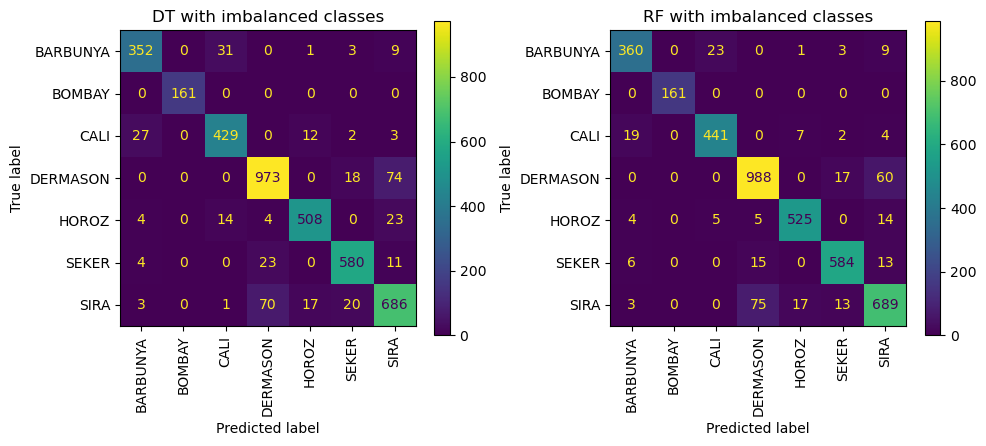

In [69]:
# Plotting confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 16))

cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(cm, display_labels = sorted(set(y_test['Class'])))
disp.plot(ax=axes[0], colorbar = False)
axes[0].set_title('DT with imbalanced classes')
axes[0].tick_params(axis='x', rotation=90)
plt.colorbar(disp.im_, ax=axes[0], shrink=0.2)

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(cm, display_labels = sorted(set(y_test['Class'])))
disp.plot(ax=axes[1], colorbar = False)
axes[1].set_title('RF with imbalanced classes')
axes[1].tick_params(axis='x', rotation=90)
plt.colorbar(disp.im_, ax=axes[1], shrink=0.2)

plt.tight_layout()
plt.show()

Dermanson beans are often classified as Sira ones. Knowing that these two classes contains more samples than the rest, the model can be too simple to capture the complexity of data or a new informative feature to discriminate these two classes should be used.

### Decision Tree with balanced classes

In [70]:
# Defining the hyperparameter distribution for random search
param_dt = {
    'dt__criterion': ['gini', 'entropy', 'log_loss'],
    'dt__max_depth': [None] + list(range(5, 20)),
    'dt__min_samples_split': randint(2, 20),
    'dt__min_samples_leaf': randint(1, 20),
    'dt__max_features': [None, 'sqrt', 'log2']}

In [71]:
# After oversampling the training data with SMOTE, AGAIN finding and evaluating the optimal model
smote = SMOTE(random_state=42)
pipeline = Pipeline([("smote", smote, ("dt", tree_clf)])         # Defining an imblearn Pipeline: when passed to sklearn's RandomizedSearchCV, the transformations (oversampling
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # in this case) appear only to be applied to the data on the training folds, and not the validation folds
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dt, n_iter=100, cv=kf, scoring='f1_weighted', random_state=42, n_jobs = -1)
random_search.fit(X_train, y_train)
print("Best hyperparameters found:", random_search.best_params_)

best_clf = random_search.best_estimator_
y_pred_dt = best_clf.predict(X_test)
results_df['DF + oversampling'] = calculate_metrics(y_test, y_pred_dt)
results_df

Best hyperparameters found: {'dt__criterion': 'gini', 'dt__max_depth': 8, 'dt__max_features': None, 'dt__min_samples_leaf': 16, 'dt__min_samples_split': 5}


,DT,RF,DF + oversampling
Precision,0.9082,0.9225,0.9038
Recall,0.9079,0.9225,0.9033
F1 score,0.9080,0.9224,0.9034
Accuracy,0.9079,0.9225,0.9033


In [72]:
# Evaluating the model by classes
results_df_class = calculate_metrics_classes(y_test, y_pred_dt)
results_df_class

,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Precision,0.8976,1.0,0.9010,0.9096,0.9403,0.9359,0.8313
Recall,0.8636,1.0,0.9239,0.8977,0.9403,0.9207,0.8595
F1 score,0.8803,1.0,0.9123,0.9036,0.9403,0.9282,0.8452


### Random Forest with balanced classes

In [74]:
# Defining the hyperparameter distribution for random search
param_rf = {
    'rf__n_estimators': randint(50, 300),
    'rf__max_depth': [None] + list(range(5, 20)),
    'rf__min_samples_split': randint(2, 20),
    'rf__min_samples_leaf': randint(1, 20),
    'rf__max_features': [None, 'sqrt', 'log2'],
    'rf__criterion': ['gini', 'entropy', 'log_loss'],
    'rf__bootstrap': [True, False]}

In [77]:
# After oversampling the training data with SMOTE, AGAIN finding, training and evaluating the optimal model
pipeline = Pipeline([("smote", SMOTE()), ("rf", rf_clf)])
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(pipeline, param_distributions=param_rf, n_iter=100, cv=kf, scoring='f1_weighted', random_state=42, n_jobs = -1)
random_search.fit(X_train, y_train)
print("Best hyperparameters found:", random_search.best_params_)

best_rf_clf = random_search.best_estimator_
y_pred_rf = best_rf_clf.predict(X_test)
results_df['RF + oversampling'] = calculate_metrics(y_test, y_pred_rf)
results_df

Best hyperparameters found: {'rf__bootstrap': True, 'rf__criterion': 'log_loss', 'rf__max_depth': 18, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 18, 'rf__n_estimators': 229}


,DT,RF,DF + oversampling,RF + oversampling
Precision,0.9082,0.9225,0.9038,0.9207
Recall,0.9079,0.9225,0.9033,0.9205
F1 score,0.9080,0.9224,0.9034,0.9206
Accuracy,0.9079,0.9225,0.9033,0.9205


The test results show that classification using any Random Forest achieves better results than any Decision Tree. On the other hand, Random Forest trained with imbalanced data was slightly better than the one trained with balanced data.

In [78]:
# Evaluating the model by classes
results_df_class = calculate_metrics_classes(y_test, y_pred_rf)
results_df_class

,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Precision,0.9188,1.0,0.9290,0.9237,0.9561,0.9373,0.8594
Recall,0.9141,1.0,0.9408,0.9099,0.9458,0.9434,0.8745
F1 score,0.9165,1.0,0.9349,0.9167,0.9509,0.9403,0.8669


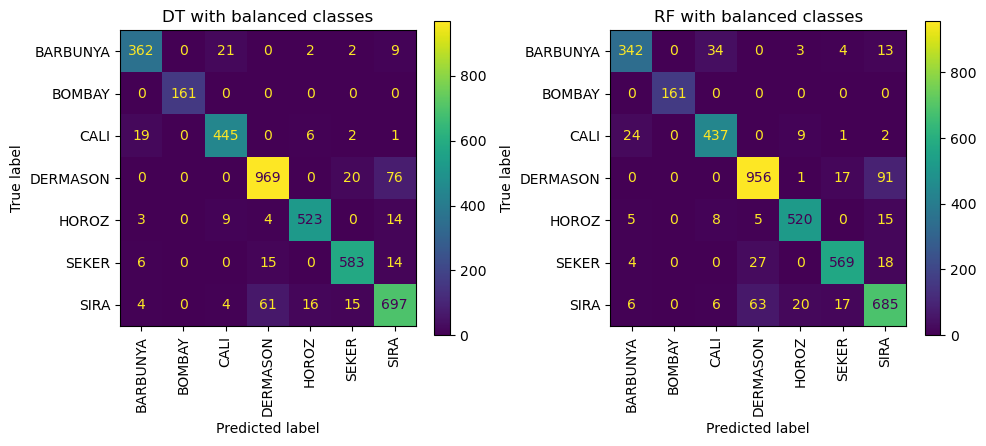

In [79]:
# Plotting confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 16))

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(cm, display_labels = sorted(set(y_test['Class'])))
disp.plot(ax=axes[0], colorbar = False)
axes[0].set_title('DT with balanced classes')
axes[0].tick_params(axis='x', rotation=90)
plt.colorbar(disp.im_, ax=axes[0], shrink=0.2)

cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(cm, display_labels = sorted(set(y_test['Class'])))
disp.plot(ax=axes[1], colorbar = False)
axes[1].set_title('RF with balanced classes')
axes[1].tick_params(axis='x', rotation=90)
plt.colorbar(disp.im_, ax=axes[1], shrink=0.2)

plt.tight_layout()
plt.show()

Missclasification increased with balanced data; Random Forests are generally robust to class imbalance due to their ensemble nature. Oversampling can lead to overfitting, especially if the oversampled data is not representative of the actual distribution of the minority class (not Bombay as commented, but Sira when compared to Dermason, although an extra informative feature may solve it as mentioned before). Random Forests may overfit to these synthetic examples, leading to decreased performance on unseen data.